In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [2]:
# Dataset
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-06-06 11:31:24--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  28.3MB/s    in 7.4s    

2021-06-06 11:31:32 (25.8 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
!ls

__notebook_source__.ipynb  ml-20m  ml-20m.zip


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
# Creating our new ids for the userId
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

# same for movieId
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [7]:
# Get user IDs, movie IDs and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = np.array(df['rating'].values, dtype=np.float32) - 2.5  # shifting

In [8]:
ratings.shape

(20000263,)

In [9]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [10]:
# Model
class Model(nn.Module):

    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):

        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim

        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2*self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)
        
        # OPTIMIZATION TRICK : INIT WITH CUSTOM RANDOM WEIGHTS
        # set the weight since N(0, 1) leads to poor results
        self.u_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
        self.m_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.M, self.D) * 0.01))

    def forward(self, u, m):

        # N --> N X D
        u = self.u_emb(u)
        m = self.m_emb(m)

        # merge the two networks
        # (out) : N X 2D
        out = torch.cat((u, m), 1)

        # ANN
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [12]:
model = Model(n_users=N, n_items=M, embed_dim=D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [13]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

## New Optimized Training Function
- Without using PyTorch's inbuilt Data Loaders
- Initializing our own random weights initially

In [14]:
def batch_gd_optimized(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
    
    train_users, train_movies, train_ratings = train_data
    test_users, test_movies, test_ratings = test_data
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    # batches per epoch
    Ntrain = len(train_users)
    batch_per_epoch = int(np.ceil(Ntrain / bs))  # bs : batch size
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        
        # shuffle each batch
        train_users, train_movies, train_ratings = shuffle(
            train_users, train_movies, train_ratings
        )
        
        for j in range(batch_per_epoch):
            
            # get the batch
            users = train_users[j*bs : (j+1)*bs]
            movies = train_movies[j*bs : (j+1)*bs]
            targets = train_ratings[j*bs : (j+1)*bs]
            
            # convert to tensor
            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)
            
            # reshape the targets
            targets = targets.view(-1, 1).float()
            
            # move data to gpu
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)
            
            # zero the parameter gradient 
            optimizer.zero_grad()
            
#             print(f"User : {users.dtype}, movies : {movies.dtype}, targets : {targets.dtype}")
            # forward pass
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        
        test_loss = []
        
        for j in range(int(np.ceil(len(test_users) / bs))):
            
            # get the batch
            users = test_users[j*bs:(j+1)*bs]
            movies = test_movies[j*bs:(j+1)*bs]
            targets = test_ratings[j*bs:(j+1)*bs]

            # convert to tensor
            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            # reshape targets
            targets = targets.view(-1, 1).float()

            # move data to GPU
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            outputs = model(users, movies)
            loss = criterion(outputs, targets).item()
            test_loss.append(loss)

        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, Duration: {dt}')

    return train_losses, test_losses

In [15]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [16]:
# Make datasets
Ntrain = int(0.8 * len(ratings))

train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]


test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

In [17]:
train_losses, test_losses = batch_gd_optimized(
    model, criterion, optimizer, 
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),10
)

Epoch 1/10, Train Loss: 0.7359, Test Loss: 0.6933, Duration: 0:01:16.112216
Epoch 2/10, Train Loss: 0.6683, Test Loss: 0.6622, Duration: 0:01:14.839794
Epoch 3/10, Train Loss: 0.6357, Test Loss: 0.6497, Duration: 0:01:14.592819
Epoch 4/10, Train Loss: 0.6144, Test Loss: 0.6396, Duration: 0:01:15.608002
Epoch 5/10, Train Loss: 0.5983, Test Loss: 0.6392, Duration: 0:01:15.081507
Epoch 6/10, Train Loss: 0.5857, Test Loss: 0.6299, Duration: 0:01:15.197418
Epoch 7/10, Train Loss: 0.5760, Test Loss: 0.6297, Duration: 0:01:14.598406
Epoch 8/10, Train Loss: 0.5685, Test Loss: 0.6289, Duration: 0:01:14.849253
Epoch 9/10, Train Loss: 0.5629, Test Loss: 0.6330, Duration: 0:01:14.960466
Epoch 10/10, Train Loss: 0.5581, Test Loss: 0.6285, Duration: 0:01:14.293260


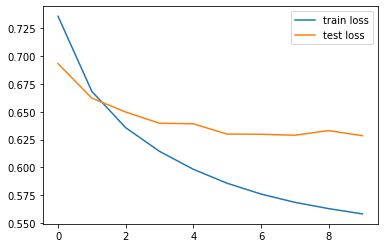

In [18]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

## Making Predictions

In [19]:
# Let's say we have to make a recommendation for user id = 1
# Find all the movies_ids for the movies they haven't watched
watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values

watched_movie_ids

array([   2,   61,   69,  108,  239,  257,  263,  465,  476,  537,  583,
        874,  891,  907, 1098, 1171, 1184, 1188, 1221, 1231, 1242, 1298,
       1326, 1494, 1528, 1616, 1684, 1881, 1885, 1886, 1887, 1888, 1889,
       1890, 1902, 2206, 2369, 2370, 2705, 2772, 2862, 2865, 3063, 3072,
       3086, 3361, 3423, 3443, 3464, 3474, 3612, 3662, 3824, 3825, 3830,
       3833, 3834, 3835, 3837, 3843, 3865], dtype=int16)

In [20]:
# movies not yet watched/rated
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()

potential_movie_ids.shape

(26683,)

In [21]:
# for each movie, we need to recommend for user id = 1
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [22]:
# Convert to torch tensor
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

# get predictions
with torch.no_grad():
    predictions = model(t_user_ids, t_movie_ids)

In [23]:
# Convert predictions to Numpy
predictions_np = predictions.cpu().numpy().flatten()

# Get sorted index for predictions
sort_idx = np.argsort(-predictions_np)  # '-' used so as to sort it in descending order

In [24]:
predictions_np

array([1.6599808 , 0.95065117, 1.5960566 , ..., 1.1325706 , 1.2173386 ,
       1.1743746 ], dtype=float32)

In [25]:
sort_idx

array([   51,   212,    26, ..., 11793,  7944,  1557])

In [28]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
    print(f"Movie : {movie}, Score : {score}")

Movie : 1356, Score : 2.8185153007507324
Movie : 1244, Score : 2.638202667236328
Movie : 1173, Score : 2.6351096630096436
Movie : 1259, Score : 2.6345722675323486
Movie : 1212, Score : 2.616608142852783
Movie : 1195, Score : 2.6164629459381104
Movie : 843, Score : 2.598625898361206
Movie : 936, Score : 2.579066514968872
Movie : 1175, Score : 2.573556423187256
Movie : 1017, Score : 2.5655264854431152
